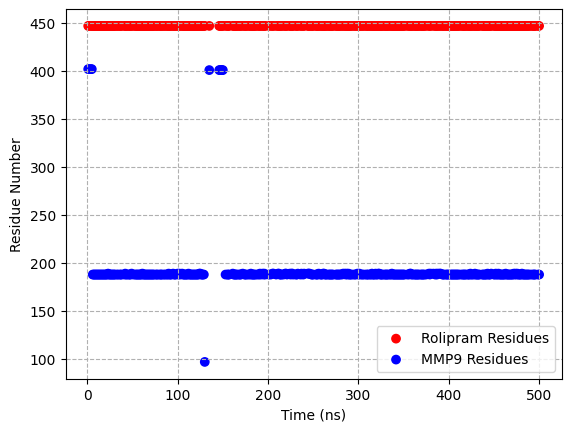

In [ ]:
import re
import matplotlib.pyplot as plt
import numpy as np

# Read the contents of the text file
with open('hbond_1l6j_roli_500_1.txt', 'r') as file:
    data = file.read()

# Regular expression pattern to match frame numbers and atom IDs
pattern = r'Current Frame: (\d+)\n<AtomGroup .+ resid (\d+) .+ segid'
# Find all matches using the pattern
matches = np.array(re.findall(pattern, data), dtype=np.int64)
frames1 = matches[:, 0]
atoms_ids1 = matches[:, 1] + 39  # Add 39 to each residue number

# Define the threshold number
threshold = 444

# Initialize empty lists to store the colors and labels
colors = []
labels = []

# Iterate through the atoms_ids1 array
for value in atoms_ids1:
    if value >= threshold:
        colors.append('red')
        labels.append('Rolipram Residues')
    else:
        colors.append('blue')
        labels.append('MMP9 Residues')

plt.scatter(frames1 / 100, atoms_ids1, color=colors, label=labels[0])

pattern2 = r'Current Frame: (\d+)\n<AtomGroup .+ resid (\d+) .+ segid .+ segid .+ segid'
matches2 = np.array(re.findall(pattern2, data), dtype=np.int64)
frames2 = matches2[:, 0]
atoms_ids2 = matches2[:, 1] + 39  # Add 39 to each residue number to match actual protein residue number
# Check for correct protein residue numbers in original file, MDAnalysis sometimes miscalculates
# it if more than one chains are there

# Initialize empty lists to store the colors and labels for the second set
colors = []
labels = []

# Iterate through the atoms_ids2 array
for value in atoms_ids2:
    if value >= threshold:
        colors.append('red')
        labels.append('Rolipram Residues')
    else:
        colors.append('blue')
        labels.append('MMP9 Residues')

plt.scatter(frames2 / 100, atoms_ids2, color=colors, label=labels[0])
# you need to divide frames with 100 because the frame number is 100 times of time in nanosecond
plt.xlabel("Time (ns)")
plt.ylabel('Residue Number')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()


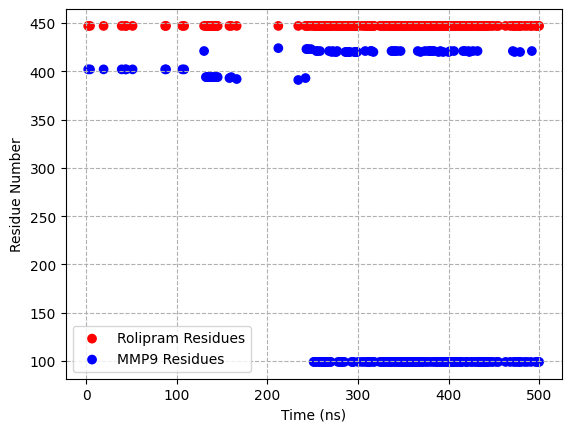

In [ ]:
import re
import matplotlib.pyplot as plt
import numpy as np

# Read the contents of the text file
with open('hbond_1l6j_roli_500_2.txt', 'r') as file:
    data = file.read()

# Regular expression pattern to match frame numbers and atom IDs
pattern = r'Current Frame: (\d+)\n<AtomGroup .+ resid (\d+) .+ segid'
# Find all matches using the pattern
matches = np.array(re.findall(pattern, data), dtype=np.int64)
frames1 = matches[:, 0]
atoms_ids1 = matches[:, 1] + 39  # Add 39 to each residue number

# Define the threshold number
threshold = 444

# Initialize empty lists to store the colors and labels
colors = []
labels = []

# Iterate through the atoms_ids1 array
for value in atoms_ids1:
    if value >= threshold:
        colors.append('red')
        labels.append('Rolipram Residues')
    else:
        colors.append('blue')
        labels.append('MMP9 Residues')

plt.scatter(frames1 / 100, atoms_ids1, color=colors, label=labels[0])

pattern2 = r'Current Frame: (\d+)\n<AtomGroup .+ resid (\d+) .+ segid .+ segid .+ segid'
matches2 = np.array(re.findall(pattern2, data), dtype=np.int64)
frames2 = matches2[:, 0]
atoms_ids2 = matches2[:, 1] + 39  # Add 39 to each residue number

# Initialize empty lists to store the colors and labels for the second set
colors = []
labels = []

# Iterate through the atoms_ids2 array
for value in atoms_ids2:
    if value >= threshold:
        colors.append('red')
        labels.append('Rolipram Residues')
    else:
        colors.append('blue')
        labels.append('MMP9 Residues')

plt.scatter(frames2 / 100, atoms_ids2, color=colors, label=labels[0])
plt.xlabel("Time (ns)")
plt.ylabel('Residue Number')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()


First, we need to dump the first frame of MD simulation as pdb file.

`gmx_mpi trjconv -s md.tpr -f md_center.xtc -o start.pdb -dump 0`

Output should be `0` means `System`

Then, generating the eigenvectors

`printf '4\n4\n' | gmx_mpi covar -s start.pdb -f md_center.xtc -o eigenvalues.xvg -v eigenvectors.trr -xpma covapic.xpm`

Followed by `gmx anaeig` to generate pc1 and pc2 files

`printf '4\n4\n' | gmx_mpi anaeig -f md_center.xtc -s start.pdb -v eigenvectors.trr -last 1 -proj pc1.xvg`

`printf '4\n4\n' | gmx_mpi anaeig -f md_center.xtc -s start.pdb -v eigenvectors.trr -first 2 -last 2 -proj pc2.xvg`

Use these two xvg files (pc1.xvg and pc2.xvg) to generate the following plots.

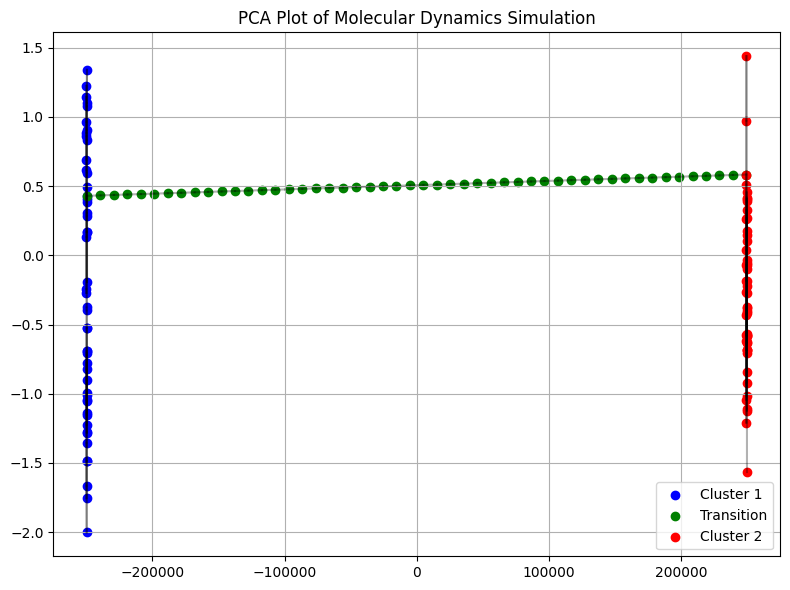

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the data from 47-pc1.xvg and 47-pc2.xvg files
# Each file is expected to have two columns, ignoring lines starting with '@' and '&'
pca1_data = np.loadtxt('pc1_1l6j_roli_500_1.xvg', comments=['@', '&'])[:, :2]  # Load only the first two columns
pca2_data = np.loadtxt('pc2_1l6j_roli_500_1.xvg', comments=['@', '&'])[:, :2]  # Load only the first two columns

# Define clusters and interpolate between them
cluster1 = pca1_data[:50]  # First 50 data points from 47-pc1.xvg
cluster2 = pca2_data[-50:]  # Last 50 data points from 47-pc2.xvg

# Transition points (linear interpolation between the two clusters)
transition = np.linspace(0, 1, 50).reshape(-1, 1)
interpolation = (1 - transition) * cluster1[-1] + transition * cluster2[0]

# Combine the datasets
data = np.vstack([cluster1, interpolation, cluster2])

# Perform PCA on the combined dataset
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)



# Plotting the PCA plot
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:50, 0], principal_components[:50, 1], c='blue', label='Cluster 1')
plt.scatter(principal_components[50:100, 0], principal_components[50:100, 1], c='green', label='Transition')
plt.scatter(principal_components[100:, 0], principal_components[100:, 1], c='red', label='Cluster 2')

# Adding lines to show time progression
for i in range(len(principal_components) - 1):
    plt.plot(principal_components[i:i+2, 0], principal_components[i:i+2, 1], 'k-', alpha=0.3)

# Labels and title
#plt.xlabel(f'PC1 ({explained_variance[0]:.2f}% variance)')
#plt.ylabel(f'PC2 ({explained_variance[1]:.2f}% variance)')
plt.title('PCA Plot of Molecular Dynamics Simulation')

# Show legend
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure
plt.savefig("pca_plot.png")

# Show the plot
plt.show()

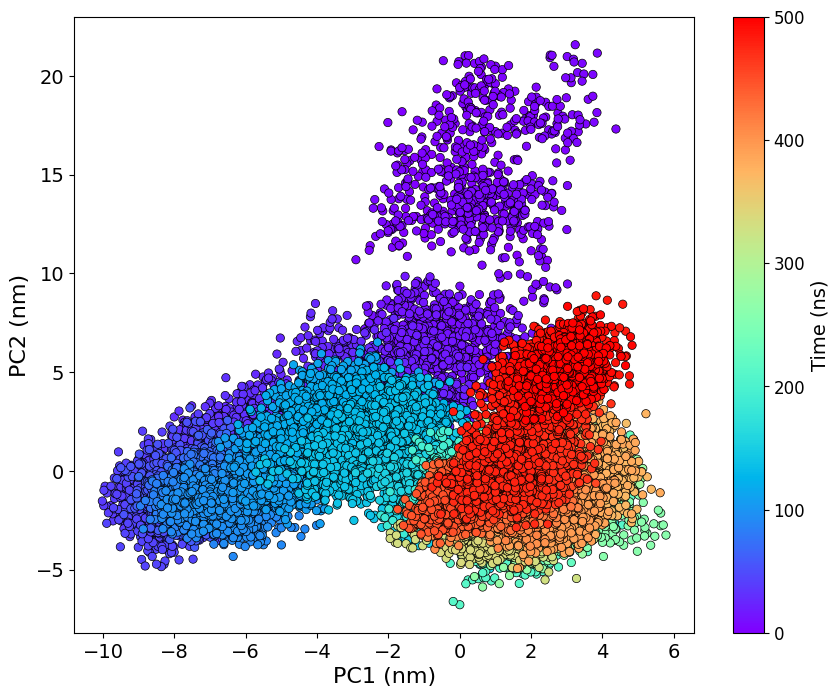

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for PC1 and PC2 XVG files
pc1_file = 'pc1_1l6j_roli_500_1.xvg'
pc2_file = 'pc2_1l6j_roli_500_1.xvg'

# Read the XVG files
time_pc1, pc1 = read_xvg(pc1_file, skip_header=24)  # Adjust the skip_header value as needed
time_pc2, pc2 = read_xvg(pc2_file, skip_header=24)

time_pc1 = time_pc1/1000
time_pc2 = time_pc2/1000

# Ensure the time arrays match
assert np.array_equal(time_pc1, time_pc2), "Time arrays do not match between PC1 and PC2 files."

# Create a scatter plot with a color gradient based on time
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pc1, pc2, c=time_pc1, cmap='rainbow', edgecolor='k', linewidth = 0.5)

# Add colorbar and set its label size
cbar = plt.colorbar(scatter)
cbar.set_label('Time (ns)', fontsize=14)
cbar.ax.tick_params(labelsize=12)  # Set colorbar label size

# Add labels and title
plt.xlabel('PC1 (nm)', fontsize=16)
plt.ylabel('PC2 (nm)', fontsize=16)

# Set axis tick label sizes
plt.tick_params(axis='x', labelsize=14)  # Set x-axis tick label size
plt.tick_params(axis='y', labelsize=14)  # Set y-axis tick label size

# Save the plot as an SVG file
plt.savefig('PCA_time_gradient_2D.jpg', dpi = 300)

# Show plot
plt.show()

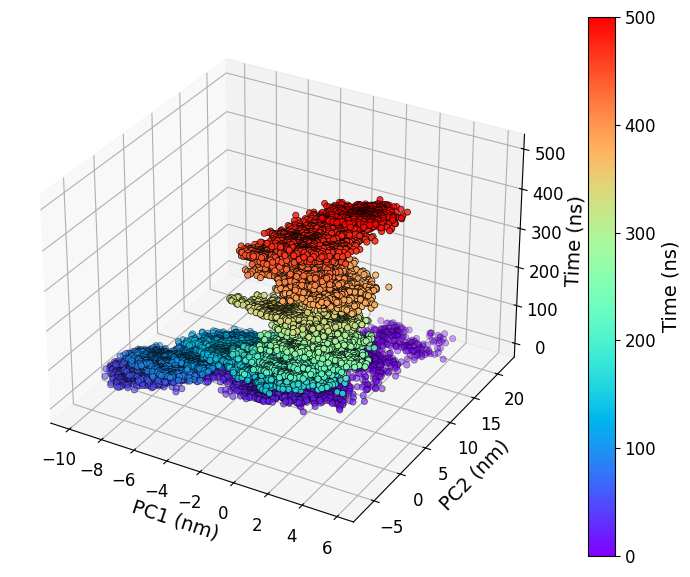

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for PC1 and PC2 XVG files
pc1_file = 'pc1_1l6j_roli_500_1.xvg'
pc2_file = 'pc2_1l6j_roli_500_1.xvg'

# Read the XVG files
time_pc1, pc1 = read_xvg(pc1_file, skip_header=24)  # Adjust the skip_header value as needed
time_pc2, pc2 = read_xvg(pc2_file, skip_header=24)

time_pc1 = time_pc1/1000
time_pc2 = time_pc2/1000

# Ensure the time arrays match
assert np.array_equal(time_pc1, time_pc2), "Time arrays do not match between PC1 and PC2 files."

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting the scatter with time as the Z-axis
scatter = ax.scatter(pc1, pc2, time_pc1, c=time_pc1, cmap='rainbow', edgecolor='k', linewidth = 0.5)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Time (ns)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Set labels
ax.set_xlabel('PC1 (nm)', fontsize=14)
ax.set_ylabel('PC2 (nm)', fontsize=14)
ax.set_zlabel('Time (ns)', fontsize=14)

# Set tick label sizes
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='z', labelsize=12)

# Save the plot as an SVG file
plt.savefig('PCA_time gradient-3D_1l6j_roli_1.jpg', dpi = 300)

# Show plot
plt.show()

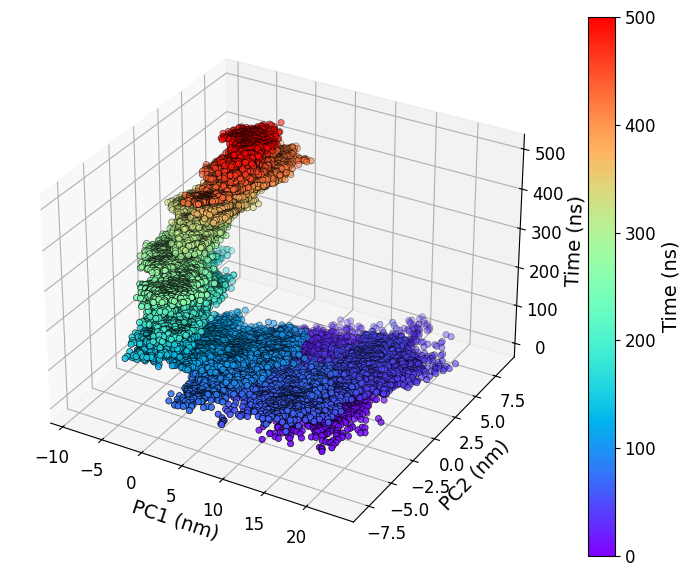

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for PC1 and PC2 XVG files
pc1_file = 'pc1_1l6j_roli_500_2.xvg'
pc2_file = 'pc2_1l6j_roli_500_2.xvg'

# Read the XVG files
time_pc1, pc1 = read_xvg(pc1_file, skip_header=24)  # Adjust the skip_header value as needed
time_pc2, pc2 = read_xvg(pc2_file, skip_header=24)

time_pc1 = time_pc1/1000
time_pc2 = time_pc2/1000

# Ensure the time arrays match
assert np.array_equal(time_pc1, time_pc2), "Time arrays do not match between PC1 and PC2 files."

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting the scatter with time as the Z-axis
scatter = ax.scatter(pc1, pc2, time_pc1, c=time_pc1, cmap='rainbow', edgecolor='k', linewidth = 0.5)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Time (ns)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Set labels
ax.set_xlabel('PC1 (nm)', fontsize=14)
ax.set_ylabel('PC2 (nm)', fontsize=14)
ax.set_zlabel('Time (ns)', fontsize=14)

# Set tick label sizes
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='z', labelsize=12)

# Save the plot as an SVG file
plt.savefig('PCA_time gradient-3D_1l6j_roli_2.jpg', dpi = 300)

# Show plot
plt.show()

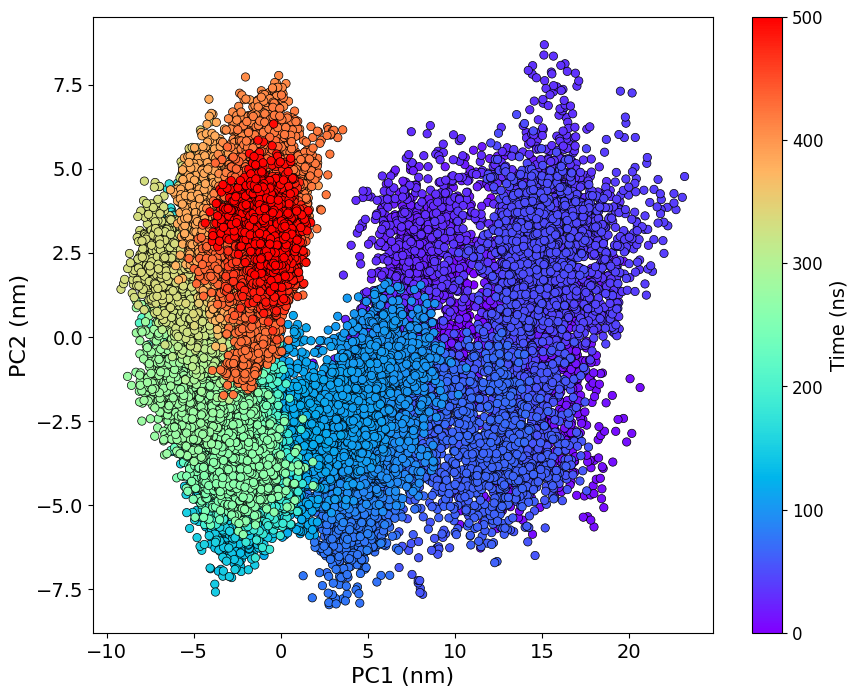

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for PC1 and PC2 XVG files
pc1_file = 'pc1_1l6j_roli_500_2.xvg'
pc2_file = 'pc2_1l6j_roli_500_2.xvg'

# Read the XVG files
time_pc1, pc1 = read_xvg(pc1_file, skip_header=24)  # Adjust the skip_header value as needed
time_pc2, pc2 = read_xvg(pc2_file, skip_header=24)

time_pc1 = time_pc1/1000
time_pc2 = time_pc2/1000

# Ensure the time arrays match
assert np.array_equal(time_pc1, time_pc2), "Time arrays do not match between PC1 and PC2 files."

# Create a scatter plot with a color gradient based on time
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pc1, pc2, c=time_pc1, cmap='rainbow', edgecolor='k', linewidth = 0.5)

# Add colorbar and set its label size
cbar = plt.colorbar(scatter)
cbar.set_label('Time (ns)', fontsize=14)
cbar.ax.tick_params(labelsize=12)  # Set colorbar label size

# Add labels and title
plt.xlabel('PC1 (nm)', fontsize=16)
plt.ylabel('PC2 (nm)', fontsize=16)

# Set axis tick label sizes
plt.tick_params(axis='x', labelsize=14)  # Set x-axis tick label size
plt.tick_params(axis='y', labelsize=14)  # Set y-axis tick label size

# Save the plot as an SVG file
plt.savefig('PCA_time_gradient_2D_2.jpg', dpi = 300)

# Show plot
plt.show()

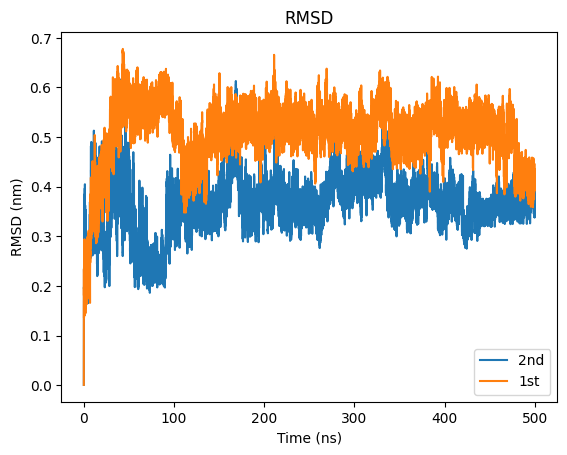

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read the data from XVG files
data1 = np.loadtxt('rmsd_1l6j_500_roli_2.xvg', comments=['@', '#'])
data2 = np.loadtxt('rmsd_1l6j_roli_500_1.xvg', comments=['@', '#'])

# Plot the data
plt.plot(data1[:, 0], data1[:, 1], label='2nd')
plt.plot(data2[:, 0], data2[:, 1], label='1st')

# Customize the plot
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (nm)')
plt.title('RMSD')
plt.legend()

# Display the plot
plt.savefig('RMSD_1l6j_duplicate.tif', dpi=300)
plt.show()

NameError: name 'explained_variance' is not defined

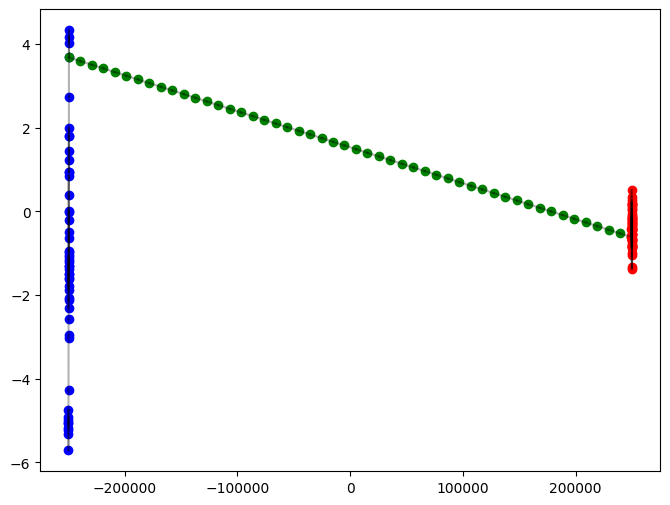

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the data from 47-pc1.xvg and 47-pc2.xvg files
# Each file is expected to have two columns, ignoring lines starting with '@' and '&'
pca1_data = np.loadtxt('pc1_1l6j_roli_500_2.xvg', comments=['@', '&'])[:, :2]  # Load only the first two columns
pca2_data = np.loadtxt('pc2_1l6j_roli_500_2.xvg', comments=['@', '&'])[:, :2]  # Load only the first two columns

# Define clusters and interpolate between them
cluster1 = pca1_data[:50]  # First 50 data points from 47-pc1.xvg
cluster2 = pca2_data[-50:]  # Last 50 data points from 47-pc2.xvg

# Transition points (linear interpolation between the two clusters)
transition = np.linspace(0, 1, 50).reshape(-1, 1)
interpolation = (1 - transition) * cluster1[-1] + transition * cluster2[0]

# Combine the datasets
data = np.vstack([cluster1, interpolation, cluster2])

# Perform PCA on the combined dataset
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)



# Plotting the PCA plot
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:50, 0], principal_components[:50, 1], c='blue', label='Cluster 1')
plt.scatter(principal_components[50:100, 0], principal_components[50:100, 1], c='green', label='Transition')
plt.scatter(principal_components[100:, 0], principal_components[100:, 1], c='red', label='Cluster 2')

# Adding lines to show time progression
for i in range(len(principal_components) - 1):
    plt.plot(principal_components[i:i+2, 0], principal_components[i:i+2, 1], 'k-', alpha=0.3)

# Labels and title
plt.xlabel(f'PC1 ({explained_variance[0]:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2f}% variance)')
plt.title('PCA Plot of Molecular Dynamics Simulation')

# Show legend
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure
plt.savefig("pca_plot.png")

# Show the plot
plt.show()

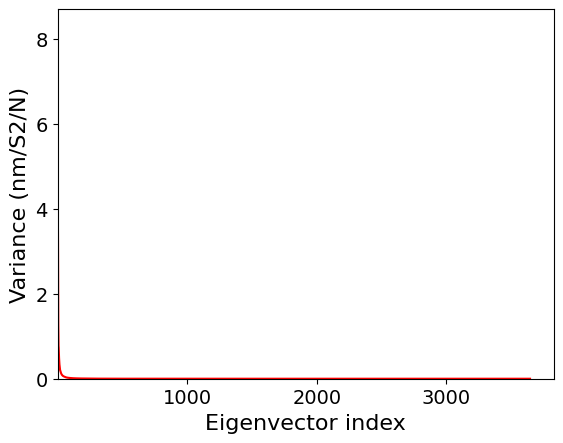

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to read XVG file and extract data
def read_xvg(file_path):
    data = np.genfromtxt(file_path, skip_header=18)  # Adjust skip_header based on your XVG file format
    time_points = data[:, 0]
    rmsd_values = data[:, 1]
    return time_points, rmsd_values

# Replace these placeholders with your actual file paths
D1_path = 'eigenvalues_1l6j_roli_500_1.xvg'

# Read data from XVG files
time_D1, D1_data = read_xvg(D1_path)


# Create a new figure
fig, ax = plt.subplots()

# Plot the data
ax.plot(time_D1, D1_data, color='red')

# Set axis limits
ax.set_xlim(1, )
ax.set_ylim(0, )

# Add labels and legend with custom font style
ax.set_xlabel('Eigenvector index', fontsize=16)  # Change 'Arial' to your desired font
ax.set_ylabel('Variance (nm/S2/N)', fontsize=16)  # Change 'Arial' to your desired font

# Adjust number of markings on the x and y axes
ax.xaxis.set_major_locator(plt.MaxNLocator(4))  # Adjust the number of markings on x-axis
ax.yaxis.set_major_locator(plt.MaxNLocator(5))  # Adjust the number of markings on y-axis

# Adjust the marking size
ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust the size of markings

# Save the plot as an SVG file
#plt.savefig('Figures/Covariance.svg', format='svg', bbox_inches='tight')

# Show the plot
plt.show()

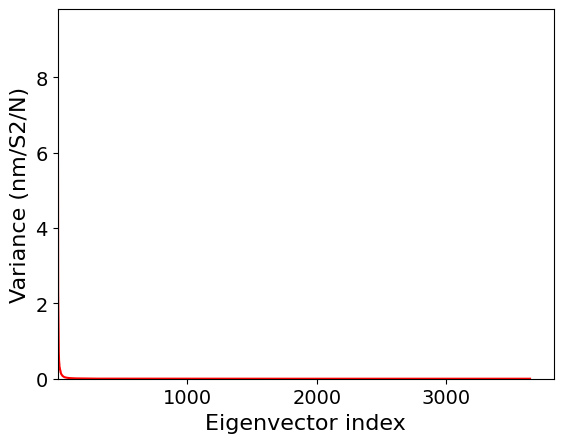

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to read XVG file and extract data
def read_xvg(file_path):
    data = np.genfromtxt(file_path, skip_header=18)  # Adjust skip_header based on your XVG file format
    time_points = data[:, 0]
    rmsd_values = data[:, 1]
    return time_points, rmsd_values

# Replace these placeholders with your actual file paths
D1_path = 'eigenvalues_1l6j_roli_500_2.xvg'

# Read data from XVG files
time_D1, D1_data = read_xvg(D1_path)


# Create a new figure
fig, ax = plt.subplots()

# Plot the data
ax.plot(time_D1, D1_data, color='red')

# Set axis limits
ax.set_xlim(1, )
ax.set_ylim(0, )

# Add labels and legend with custom font style
ax.set_xlabel('Eigenvector index', fontsize=16)  # Change 'Arial' to your desired font
ax.set_ylabel('Variance (nm/S2/N)', fontsize=16)  # Change 'Arial' to your desired font

# Adjust number of markings on the x and y axes
ax.xaxis.set_major_locator(plt.MaxNLocator(4))  # Adjust the number of markings on x-axis
ax.yaxis.set_major_locator(plt.MaxNLocator(5))  # Adjust the number of markings on y-axis

# Adjust the marking size
ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust the size of markings

# Save the plot as an SVG file
#plt.savefig('Figures/Covariance.svg', format='svg', bbox_inches='tight')

# Show the plot
plt.show()

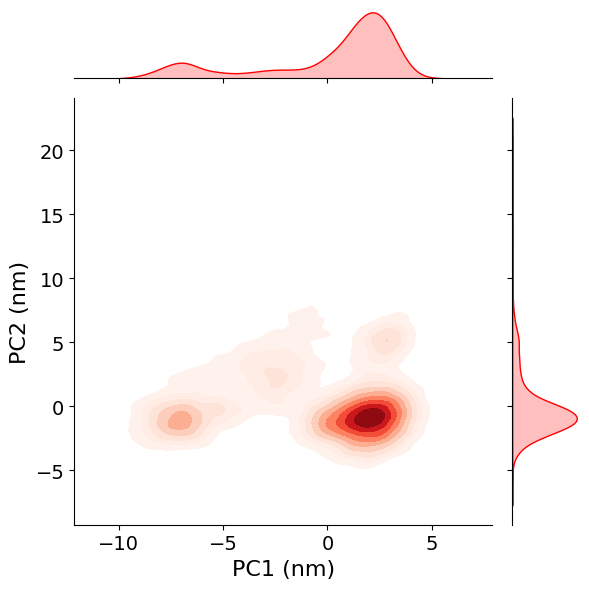

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for RMSD and radius of gyration XVG files
rmsd_file = 'pc1_1l6j_roli_500_1.xvg'
radius_file = 'pc2_1l6j_roli_500_1.xvg'

# Read data from XVG files with skip headers
time_rmsd, rmsd_data = read_xvg(rmsd_file, skip_header=24)  # Adjust skip_header based on your file format
time_radius, radius_data = read_xvg(radius_file, skip_header=24)  # Adjust skip_header based on your file format

# Create joint plot with KDE and filled marginal distributions
joint_plot = sns.jointplot(x=rmsd_data, y=radius_data, color='red', kind='kde', cmap='Reds', fill=True, bw_adjust=0.5)

# Adjusting tick parameters for font size and font style
joint_plot.ax_joint.tick_params(axis='both', which='major', labelsize=14)

# Set the number of markings (ticks) on the x and y axes
joint_plot.ax_joint.locator_params(nbins=7)

# Add x-label and y-label
joint_plot.set_axis_labels('PC1 (nm)', 'PC2 (nm)', fontsize=16)

# Tight layout to prevent labels from being cut off
plt.tight_layout()

# Save the plot as an SVG file
#plt.savefig('Figures/PCA.svg', format='svg')

# Show the plot
plt.show()


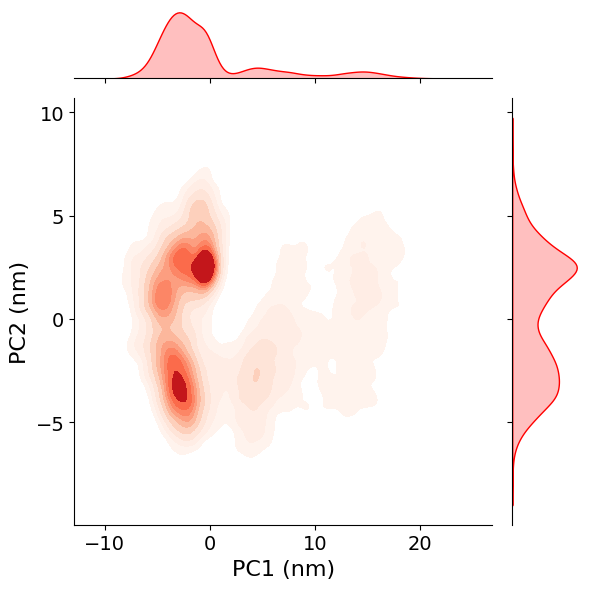

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for RMSD and radius of gyration XVG files
rmsd_file = 'pc1_1l6j_roli_500_2.xvg'
radius_file = 'pc2_1l6j_roli_500_2.xvg'

# Read data from XVG files with skip headers
time_rmsd, rmsd_data = read_xvg(rmsd_file, skip_header=24)  # Adjust skip_header based on your file format
time_radius, radius_data = read_xvg(radius_file, skip_header=24)  # Adjust skip_header based on your file format

# Create joint plot with KDE and filled marginal distributions
joint_plot = sns.jointplot(x=rmsd_data, y=radius_data, color='red', kind='kde', cmap='Reds', fill=True, bw_adjust=0.5)

# Adjusting tick parameters for font size and font style
joint_plot.ax_joint.tick_params(axis='both', which='major', labelsize=14)

# Set the number of markings (ticks) on the x and y axes
joint_plot.ax_joint.locator_params(nbins=7)

# Add x-label and y-label
joint_plot.set_axis_labels('PC1 (nm)', 'PC2 (nm)', fontsize=16)

# Tight layout to prevent labels from being cut off
plt.tight_layout()

# Save the plot as an SVG file
#plt.savefig('Figures/PCA.svg', format='svg')

# Show the plot
plt.show()


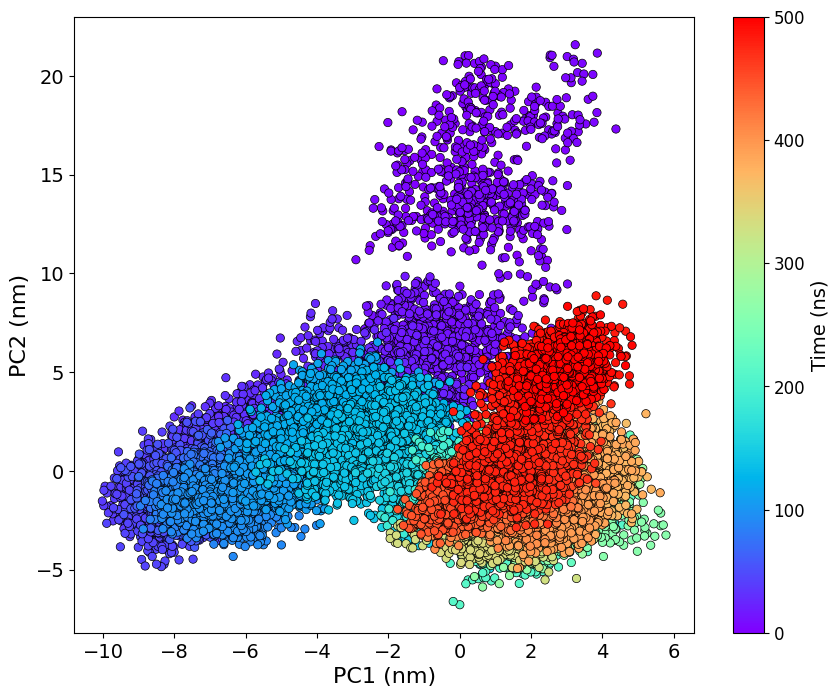

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for PC1 and PC2 XVG files
pc1_file = 'pc1_1l6j_roli_500_1.xvg'
pc2_file = 'pc2_1l6j_roli_500_1.xvg'

# Read the XVG files
time_pc1, pc1 = read_xvg(pc1_file, skip_header=24)  # Adjust the skip_header value as needed
time_pc2, pc2 = read_xvg(pc2_file, skip_header=24)

time_pc1 = time_pc1/1000
time_pc2 = time_pc2/1000

# Ensure the time arrays match
assert np.array_equal(time_pc1, time_pc2), "Time arrays do not match between PC1 and PC2 files."

# Create a scatter plot with a color gradient based on time
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pc1, pc2, c=time_pc1, cmap='rainbow', edgecolor='k', linewidth = 0.5)

# Add colorbar and set its label size
cbar = plt.colorbar(scatter)
cbar.set_label('Time (ns)', fontsize=14)
cbar.ax.tick_params(labelsize=12)  # Set colorbar label size

# Add labels and title
plt.xlabel('PC1 (nm)', fontsize=16)
plt.ylabel('PC2 (nm)', fontsize=16)

# Set axis tick label sizes
plt.tick_params(axis='x', labelsize=14)  # Set x-axis tick label size
plt.tick_params(axis='y', labelsize=14)  # Set y-axis tick label size

# Save the plot as an SVG file
#plt.savefig('Figures/PCA_time gradient.svg', format='svg')

# Show plot
plt.show()

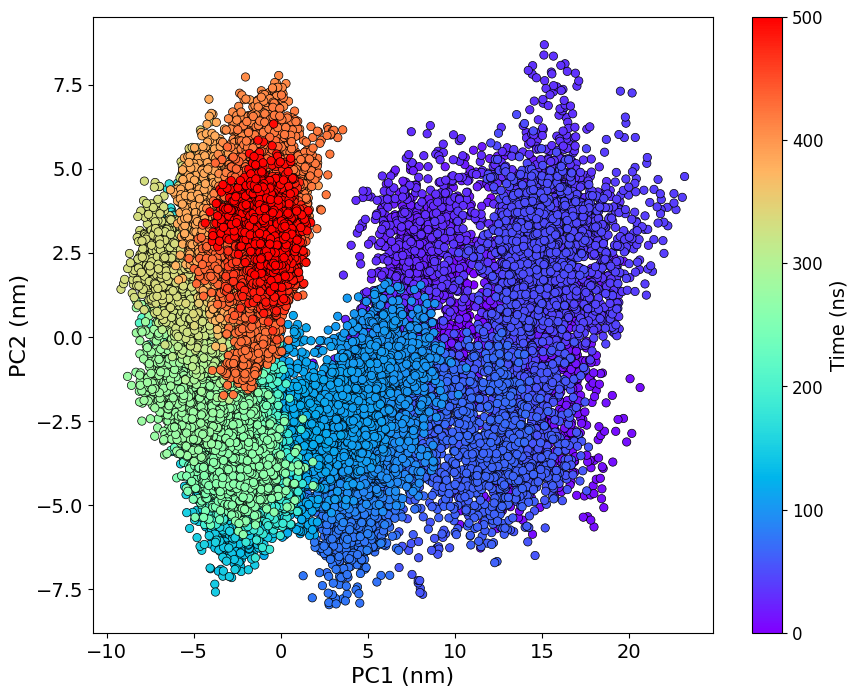

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for PC1 and PC2 XVG files
pc1_file = 'pc1_1l6j_roli_500_2.xvg'
pc2_file = 'pc2_1l6j_roli_500_2.xvg'

# Read the XVG files
time_pc1, pc1 = read_xvg(pc1_file, skip_header=24)  # Adjust the skip_header value as needed
time_pc2, pc2 = read_xvg(pc2_file, skip_header=24)

time_pc1 = time_pc1/1000
time_pc2 = time_pc2/1000

# Ensure the time arrays match
assert np.array_equal(time_pc1, time_pc2), "Time arrays do not match between PC1 and PC2 files."

# Create a scatter plot with a color gradient based on time
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pc1, pc2, c=time_pc1, cmap='rainbow', edgecolor='k', linewidth = 0.5)

# Add colorbar and set its label size
cbar = plt.colorbar(scatter)
cbar.set_label('Time (ns)', fontsize=14)
cbar.ax.tick_params(labelsize=12)  # Set colorbar label size

# Add labels and title
plt.xlabel('PC1 (nm)', fontsize=16)
plt.ylabel('PC2 (nm)', fontsize=16)

# Set axis tick label sizes
plt.tick_params(axis='x', labelsize=14)  # Set x-axis tick label size
plt.tick_params(axis='y', labelsize=14)  # Set y-axis tick label size

# Save the plot as an SVG file
#plt.savefig('Figures/PCA_time gradient.svg', format='svg')

# Show plot
plt.show()

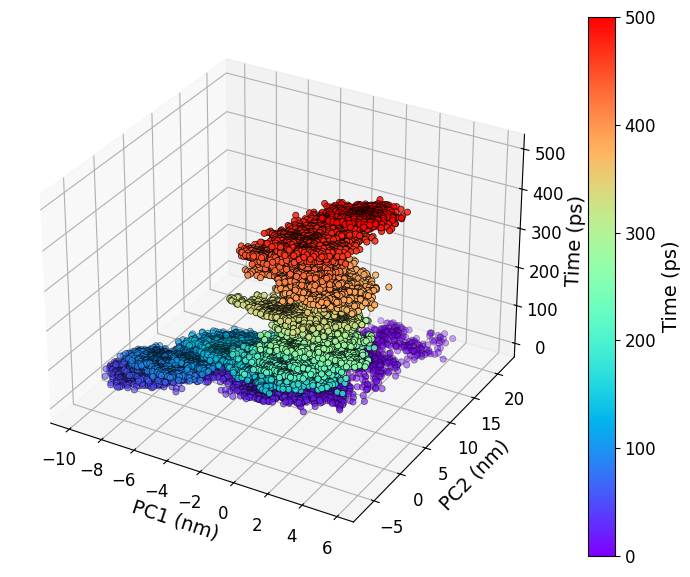

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for PC1 and PC2 XVG files
pc1_file = 'pc1_1l6j_roli_500_1.xvg'
pc2_file = 'pc2_1l6j_roli_500_1.xvg'

# Read the XVG files
time_pc1, pc1 = read_xvg(pc1_file, skip_header=24)  # Adjust the skip_header value as needed
time_pc2, pc2 = read_xvg(pc2_file, skip_header=24)

time_pc1 = time_pc1/1000
time_pc2 = time_pc2/1000

# Ensure the time arrays match
assert np.array_equal(time_pc1, time_pc2), "Time arrays do not match between PC1 and PC2 files."

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting the scatter with time as the Z-axis
scatter = ax.scatter(pc1, pc2, time_pc1, c=time_pc1, cmap='rainbow', edgecolor='k', linewidth = 0.5)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Time (ps)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Set labels
ax.set_xlabel('PC1 (nm)', fontsize=14)
ax.set_ylabel('PC2 (nm)', fontsize=14)
ax.set_zlabel('Time (ps)', fontsize=14)

# Set tick label sizes
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='z', labelsize=12)

# Save the plot as an SVG file
#plt.savefig('Figures/PCA_time gradient-3D.svg', format='svg')

# Show plot
plt.show()

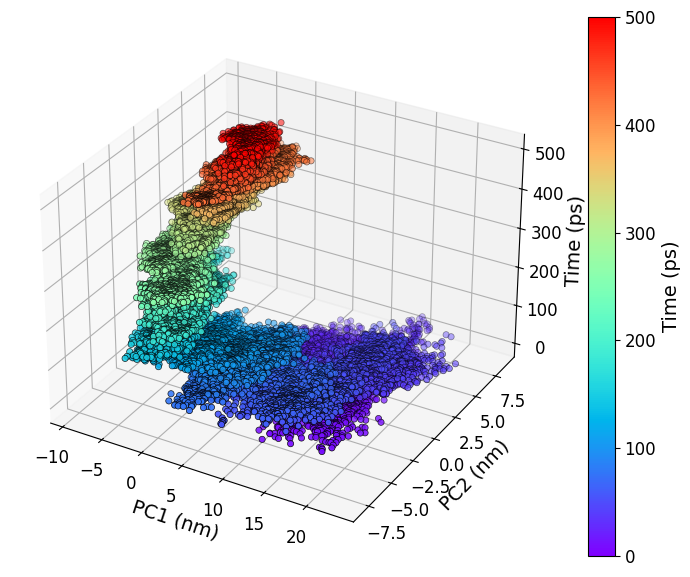

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for PC1 and PC2 XVG files
pc1_file = 'pc1_1l6j_roli_500_2.xvg'
pc2_file = 'pc2_1l6j_roli_500_2.xvg'

# Read the XVG files
time_pc1, pc1 = read_xvg(pc1_file, skip_header=24)  # Adjust the skip_header value as needed
time_pc2, pc2 = read_xvg(pc2_file, skip_header=24)

time_pc1 = time_pc1/1000
time_pc2 = time_pc2/1000

# Ensure the time arrays match
assert np.array_equal(time_pc1, time_pc2), "Time arrays do not match between PC1 and PC2 files."

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting the scatter with time as the Z-axis
scatter = ax.scatter(pc1, pc2, time_pc1, c=time_pc1, cmap='rainbow', edgecolor='k', linewidth = 0.5)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Time (ps)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Set labels
ax.set_xlabel('PC1 (nm)', fontsize=14)
ax.set_ylabel('PC2 (nm)', fontsize=14)
ax.set_zlabel('Time (ps)', fontsize=14)

# Set tick label sizes
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='z', labelsize=12)

# Save the plot as an SVG file
#plt.savefig('Figures/PCA_time gradient-3D.svg', format='svg')

# Show plot
plt.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for PC1 and PC2 XVG files
pc1_file = 'pc1_1l6j_roli_500_1.xvg'
pc2_file = 'pc2_1l6j_roli_500_1.xvg'

# Read the XVG files
time_pc1, pc1 = read_xvg(pc1_file, skip_header=24)  # Adjust the skip_header value as needed
time_pc2, pc2 = read_xvg(pc2_file, skip_header=24)

# Picoseconds to Nanoseconds
time_pc1 = time_pc1/1000
time_pc2 = time_pc2/1000

# Ensure the time arrays match
assert np.array_equal(time_pc1, time_pc2), "Time arrays do not match between PC1 and PC2 files."

# Sample every 10th point
pc1_sampled = pc1[::10]
pc2_sampled = pc2[::10]
time_pc1_sampled = time_pc1[::10]

# Create a 3D scatter plot using Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=pc1_sampled,
    y=pc2_sampled,
    z=time_pc1_sampled,
    mode='markers',
    marker=dict(
        size=5,         # Size of the markers
        color=time_pc1_sampled, # Color by time
        colorscale='rainbow', # Color scale
        opacity=0.8,
        line=dict(width=0.1, color='black')  # Edge color and thickness
    )
)])

# Set labels
fig.update_layout(
    scene=dict(
        xaxis_title='PC1 (nm)',
        yaxis_title='PC2 (nm)',
        zaxis_title='Time (ps)'
    ),
    title='3D PCA of Protein Backbone',
    width=800,
    height=700,
    margin=dict(l=0, r=0, b=0, t=50)
)

# Show plot
fig.show()

# Optionally save the plot as an HTML file
#pio.write_html(fig, file='Figures/PCA_Time_Gradient-3D.html', auto_open=True)

In [ ]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for PC1 and PC2 XVG files
pc1_file = 'pc1_1l6j_roli_500_2.xvg'
pc2_file = 'pc2_1l6j_roli_500_2.xvg'

# Read the XVG files
time_pc1, pc1 = read_xvg(pc1_file, skip_header=24)  # Adjust the skip_header value as needed
time_pc2, pc2 = read_xvg(pc2_file, skip_header=24)

# Picoseconds to Nanoseconds
time_pc1 = time_pc1/1000
time_pc2 = time_pc2/1000

# Ensure the time arrays match
assert np.array_equal(time_pc1, time_pc2), "Time arrays do not match between PC1 and PC2 files."

# Sample every 10th point
pc1_sampled = pc1[::10]
pc2_sampled = pc2[::10]
time_pc1_sampled = time_pc1[::10]

# Create a 3D scatter plot using Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=pc1_sampled,
    y=pc2_sampled,
    z=time_pc1_sampled,
    mode='markers',
    marker=dict(
        size=5,         # Size of the markers
        color=time_pc1_sampled, # Color by time
        colorscale='rainbow', # Color scale
        opacity=0.8,
        line=dict(width=0.1, color='black')  # Edge color and thickness
    )
)])

# Set labels
fig.update_layout(
    scene=dict(
        xaxis_title='PC1 (nm)',
        yaxis_title='PC2 (nm)',
        zaxis_title='Time (ps)'
    ),
    title='3D PCA of Protein Backbone',
    width=800,
    height=700,
    margin=dict(l=0, r=0, b=0, t=50)
)

# Show plot
fig.show()

# Optionally save the plot as an HTML file
#pio.write_html(fig, file='Figures/PCA_Time_Gradient-3D.html', auto_open=True)

For PCA with respect to energy, first

`paste pc1.xvg pc2.xvg | awk &#39;{print $1, $2, $4}&#39; &gt; PC1PC2.xvg`

Then, use this PC1PC2.xvg file to generate an xpm file

`gmx_mpi sham -f PC1PC2.xvg -ls FES.xpm`

Then use the following `xpm2txt.py` script to convert the .xpm file into .dat file:


In [ ]:
#!/usr/bin/env python3

import sys

"""
Utility tool to convert xpm files generated by GROMACS to a 3-column text file.
"""

USAGE = "USAGE: xpm2txt.py -f <input xpm file> -o <output txt file> [-s]\n"
USAGE += "Options:\n"
USAGE += "\t-s\t(int)\tSorts the output by a given column"
USAGE += "\n"  # always keep this line

# Parse arguments
read_input, read_output, sort = False, False, False
xpm_file, out_file, column_sort = None, None, None
for arg in sys.argv[1:]:
    if read_input:
        read_input = False
        xpm_file = arg
    elif read_output:
        read_output = False
        out_file = arg
    elif sort:
        sort = False
        column_sort = int(arg)
    if arg.startswith("-"):
        if arg == "-f":
            read_input = True
            continue
        elif arg == "-o":
            read_output = True
            continue
        elif arg == "-s":
            sort = True
        else:
            print(USAGE)
            sys.stderr.write('ERROR: Option not recognized: %s\n' % arg)
            sys.exit(1)

if not xpm_file:
    print(USAGE)
    sys.stderr.write('ERROR: You forgot to provide an input file.\n')
    sys.exit(1)
if not out_file:
    out_file = "out.txt"

# Parse XPM file
with open(xpm_file) as xpm_handle:
    xpm_data = []
    x_axis, y_axis = [], []
    letter_to_value = {}
    for line in xpm_handle:
        if line.startswith("/* x-axis"):
            x_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith("/* y-axis"):
            y_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith('"') and x_axis and y_axis:  # Read data
            xpm_data.insert(0, line.strip().strip(',')[1:-1])

        if line.startswith('"') and len(line.split()) > 4:
            letter = line.split()[0][1:]
            value = float(line.split()[-2][1:-1])
            letter_to_value[letter] = value

# Match x/y/data
txt_values = []
for y_index, data_value in enumerate(xpm_data):
    y_value = y_axis[y_index]
    for x_index, x_value in enumerate(x_axis):
        txt_values.append([x_value, y_value, letter_to_value[data_value[x_index]]])

# Apply sorting if requested
if column_sort:
    try:
        txt_values.sort(key=lambda x: x[column_sort - 1])
    except IndexError:
        print(USAGE)
        sys.stderr.write('ERROR: Column not found (%s)\n' % (column_sort))
        sys.exit(1)

# Print to file
with open(out_file, 'w') as out_handle:
    for x, y, z in txt_values:
        out_handle.write("%3.5f\t%3.5f\t%3.5f\n" % (x, y, z))

Use this above-mentioned script as

`python2 xpm2txt.py -f FES.xpm -o FEL.dat`

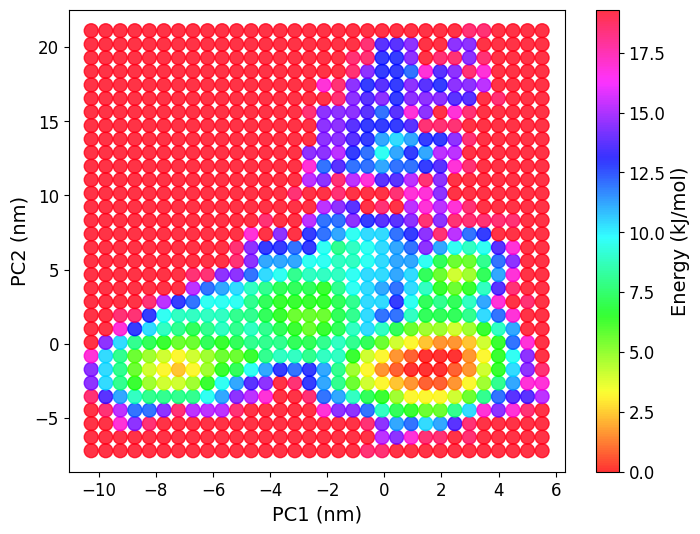

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read input data from a file
input_file = 'FEL_1l6j_roli_500_1.dat'
data = np.loadtxt(input_file)  # Assuming input data file ha6s PC1, PC2, and hbonds columns

PC1 = data[:, 0]
PC2 = data[:, 1]
hbonds = data[:, 2]

# Create a scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(PC1, PC2, c=hbonds, cmap='hsv', s=100, alpha=0.8)  # Use 'viridis' colormap for hbonds
colorbar = plt.colorbar(scatter, label='Free Energy Landscape (kJ/mol)')
colorbar.ax.tick_params(labelsize=12)  # Set font size for colorbar tick labels
colorbar.set_label('Energy (kJ/mol)', fontsize=14)  # Change colorbar label properties

plt.xlabel('PC1 (nm)', fontsize=14)
plt.ylabel('PC2 (nm)', fontsize=14)
plt.grid(False)

# Customize tick parameters on the main plot
plt.xticks(fontsize=12)  # Set font size of x-axis tick labels
plt.yticks(fontsize=12)  # Set font size of y-axis tick labels

# Save the plot to a specific file path
#plt.savefig('Figures/FEL.svg', format='svg', bbox_inches='tight')

# Show the plot (optional)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

# Function to read .dat file
def read_dat_file(filename):
    data = pd.read_csv(filename, delim_whitespace=True, header=None, names=['x', 'y', 'z'])
    data = data.fillna(0)
    return data

# Filename
filename = 'FEL_1l6j_roli_500_1.dat'

# Read Data
data = read_dat_file(filename)

# Print first few rows of the data to Debug
print("First few rows:")
print(data.head())

# Check Number of Rows and Non-Zero elements
print("\nTotal number of rows:")
print("Number of non-zero X coordinates", (data['x'] != 0).sum())
print("Number of non-zero Y coordinates", (data['y'] != 0).sum())
print("Number of non-zero Z coordinates", (data['z'] != 0).sum())

# Create 3D Scatter Plot
fig = go.Figure(data=[go.Scatter3d(
    x=data['x'],
    y=data['y'],
    z=data['z'],
    mode='markers',
    marker=dict(
        size=5,
        color=data['z'],
        colorscale='hsv',
        opacity=0.8,
        line=dict(width=0.1, color='black')
    )
)])

# Set Plot title and axis plots
fig.update_layout(
    title='FEL 3D',
    scene=dict(
        xaxis_title = 'PC1 (nm)',
        yaxis_title = 'PC2 (nm)',
        zaxis_title = 'Energy (kJ/mol)'
    )
)

# Show Plot
fig.show()

# Optionally save the plot as an HTML file
pio.write_html(fig, file='FEL-3D.html', auto_open=True)

<ipython-input-1-8d75ccf8fbf6>:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filename, delim_whitespace=True, header=None, names=['x', 'y', 'z'])


First few rows:
          x       y     z
0 -10.26460 -7.2153  19.3
1  -9.75536 -7.2153  19.3
2  -9.24608 -7.2153  19.3
3  -8.73679 -7.2153  19.3
4  -8.22751 -7.2153  19.3

Total number of rows:
Number of non-zero X coordinates 1024
Number of non-zero Y coordinates 1024
Number of non-zero Z coordinates 1018


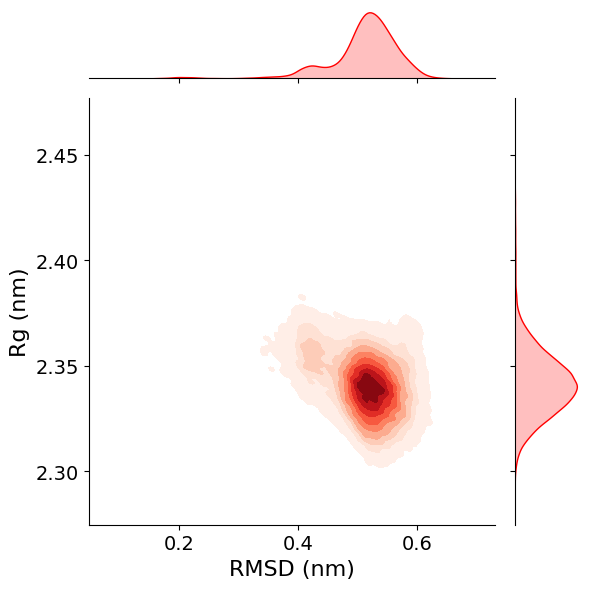

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = np.genfromtxt(file_path, skip_header=skip_header)
    return data[:, 0], data[:, 1]  # Assuming the first column is time and the second column is the data

# File paths for RMSD and radius of gyration XVG files
rmsd_file = 'rmsd_1l6j_roli_500_1.xvg'
radius_file = 'gyrate_1l6j_roli_500_1.xvg'

# Read data from XVG files with skip headers
time_rmsd, rmsd_data = read_xvg(rmsd_file, skip_header=19)  # Adjust skip_header based on your file format
time_radius, radius_data = read_xvg(radius_file, skip_header=28)  # Adjust skip_header based on your file format

# Create joint plot with KDE and filled marginal distributions
joint_plot = sns.jointplot(x=rmsd_data, y=radius_data, color='red', kind='kde', cmap='Reds', fill=True, bw_adjust=0.5)

# Adjusting tick parameters for font size and font style
joint_plot.ax_joint.tick_params(axis='both', which='major', labelsize=14)

# Set the number of markings (ticks) on the x and y axes
joint_plot.ax_joint.locator_params(nbins=5)

# Add x-label and y-label
joint_plot.set_axis_labels('RMSD (nm)', 'Rg (nm)', fontsize=16)

# Tight layout to prevent labels from being cut off
plt.tight_layout()

# Save the plot as an SVG file
#plt.savefig('Figures/Rg_vs_RMSD.svg', format='svg')

# Show the plot
plt.show()



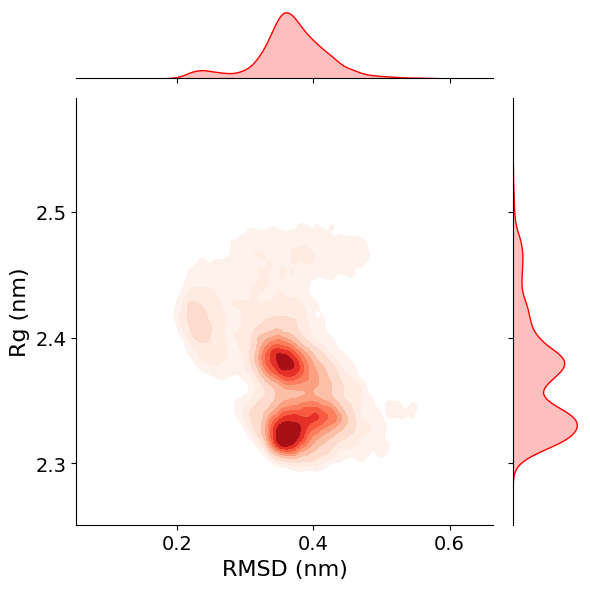

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = np.genfromtxt(file_path, skip_header=skip_header)
    return data[:, 0], data[:, 1]  # Assuming the first column is time and the second column is the data

# File paths for RMSD and radius of gyration XVG files
rmsd_file = 'rmsd_1l6j_roli_500_2.xvg'
radius_file = 'gyrate_1l6j_roli_500_2.xvg'

# Read data from XVG files with skip headers
time_rmsd, rmsd_data = read_xvg(rmsd_file, skip_header=19)  # Adjust skip_header based on your file format
time_radius, radius_data = read_xvg(radius_file, skip_header=28)  # Adjust skip_header based on your file format

# Create joint plot with KDE and filled marginal distributions
joint_plot = sns.jointplot(x=rmsd_data, y=radius_data, color='red', kind='kde', cmap='Reds', fill=True, bw_adjust=0.5)

# Adjusting tick parameters for font size and font style
joint_plot.ax_joint.tick_params(axis='both', which='major', labelsize=14)

# Set the number of markings (ticks) on the x and y axes
joint_plot.ax_joint.locator_params(nbins=5)

# Add x-label and y-label
joint_plot.set_axis_labels('RMSD (nm)', 'Rg (nm)', fontsize=16)

# Tight layout to prevent labels from being cut off
plt.tight_layout()

# Save the plot as an SVG file
#plt.savefig('Figures/Rg_vs_RMSD.svg', format='svg')

# Show the plot
plt.show()



NameError: name 'explained_variance' is not defined

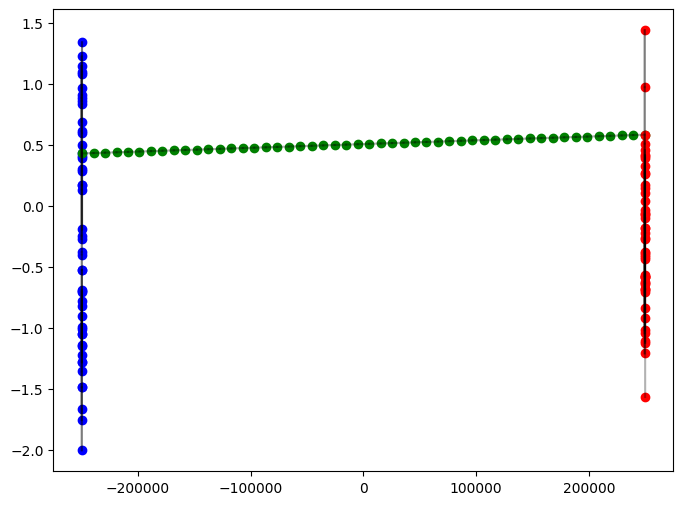

In [ ]:
import sklearn.decomposition
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the data from 47-pc1.xvg and 47-pc2.xvg files
# Each file is expected to have two columns, ignoring lines starting with '@' and '&'
pca1_data = np.loadtxt('pc1_1l6j_roli_500_1.xvg', comments=['@', '&'])[:, :2]  # Load only the first two columns
pca2_data = np.loadtxt('pc2_1l6j_roli_500_1.xvg', comments=['@', '&'])[:, :2]  # Load only the first two columns

# Define clusters and interpolate between them
cluster1 = pca1_data[:50]  # First 50 data points from 47-pc1.xvg
cluster2 = pca2_data[-50:]  # Last 50 data points from 47-pc2.xvg

# Transition points (linear interpolation between the two clusters)
transition = np.linspace(0, 1, 50).reshape(-1, 1)
interpolation = (1 - transition) * cluster1[-1] + transition * cluster2[0]

# Combine the datasets
data = np.vstack([cluster1, interpolation, cluster2])

# Perform PCA on the combined dataset
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)



# Plotting the PCA plot
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:50, 0], principal_components[:50, 1], c='blue', label='Cluster 1')
plt.scatter(principal_components[50:100, 0], principal_components[50:100, 1], c='green', label='Transition')
plt.scatter(principal_components[100:, 0], principal_components[100:, 1], c='red', label='Cluster 2')

# Adding lines to show time progression
for i in range(len(principal_components) - 1):
    plt.plot(principal_components[i:i+2, 0], principal_components[i:i+2, 1], 'k-', alpha=0.3)

# Labels and title
plt.xlabel(f'PC1 ({explained_variance[0]:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2f}% variance)')
plt.title('PCA Plot of Molecular Dynamics Simulation')

# Show legend
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure
#plt.savefig("pca_plot.png")

# Show the plot
plt.show()


NameError: name 'explained_variance' is not defined

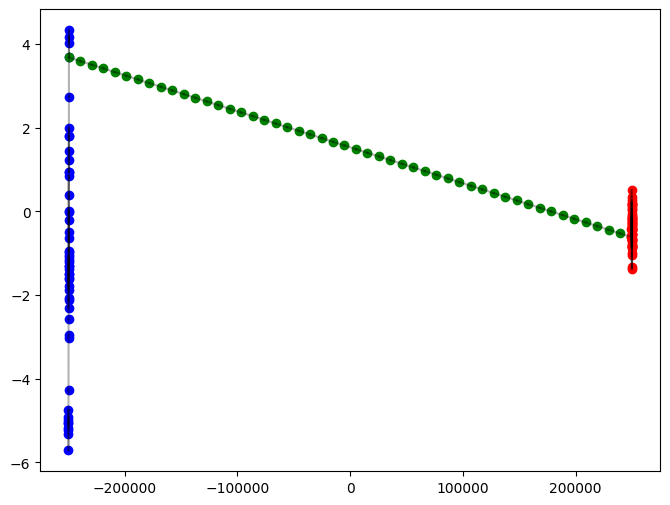

In [ ]:
import sklearn.decomposition
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the data from 47-pc1.xvg and 47-pc2.xvg files
# Each file is expected to have two columns, ignoring lines starting with '@' and '&'
pca1_data = np.loadtxt('pc1_1l6j_roli_500_2.xvg', comments=['@', '&'])[:, :2]  # Load only the first two columns
pca2_data = np.loadtxt('pc2_1l6j_roli_500_2.xvg', comments=['@', '&'])[:, :2]  # Load only the first two columns

# Define clusters and interpolate between them
cluster1 = pca1_data[:50]  # First 50 data points from 47-pc1.xvg
cluster2 = pca2_data[-50:]  # Last 50 data points from 47-pc2.xvg

# Transition points (linear interpolation between the two clusters)
transition = np.linspace(0, 1, 50).reshape(-1, 1)
interpolation = (1 - transition) * cluster1[-1] + transition * cluster2[0]

# Combine the datasets
data = np.vstack([cluster1, interpolation, cluster2])

# Perform PCA on the combined dataset
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)



# Plotting the PCA plot
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:50, 0], principal_components[:50, 1], c='blue', label='Cluster 1')
plt.scatter(principal_components[50:100, 0], principal_components[50:100, 1], c='green', label='Transition')
plt.scatter(principal_components[100:, 0], principal_components[100:, 1], c='red', label='Cluster 2')

# Adding lines to show time progression
for i in range(len(principal_components) - 1):
    plt.plot(principal_components[i:i+2, 0], principal_components[i:i+2, 1], 'k-', alpha=0.3)

# Labels and title
plt.xlabel(f'PC1 ({explained_variance[0]:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2f}% variance)')
plt.title('PCA Plot of Molecular Dynamics Simulation')

# Show legend
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure
#plt.savefig("pca_plot.png")

# Show the plot
plt.show()
